In [1]:
import numpy as np
import scipy.sparse as sp
import torch
from torch.optim import Adam, Optimizer
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from sklearn.utils.extmath import randomized_svd

from src.recommender_model import RecommenderModel
from src.utils import train_model, write_submission, plot_losses

# Matrix Factorization
This notebook provides implementations for various Matrix Factorization methods.

## 1. PureSVD
The most straight-forward method uses Singular-Value-Decomposition of the URM.


In [2]:
class PureSVD(RecommenderModel):
	def __init__(self):
		super(PureSVD, self).__init__()
		self.u: np.ndarray | None = None  # Users embeddings
		self.sigma: np.ndarray | None = None
		self.vt: np.ndarray | None = None  # Items embeddings

	def fit(self, urm: sp.csr_matrix, icm: sp.csr_matrix, urm_val: sp.csr_matrix, embeddings_dim: int = 128, num_iter: int = 5, **kwargs) -> None:
		self.urm = urm

		self.u, self.sigma, self.vt = randomized_svd(self.urm, n_components=embeddings_dim, n_iter=num_iter)

		self.urm_pred = np.dot(np.dot(self.u, np.diag(self.sigma)), self.vt)

In [3]:
pure_svd_train = train_model(PureSVD(), embedding_dim=64)

MAP@10 evaluation of the PureSVD model: 0.03239


In [4]:
pure_svd_submission = train_model(PureSVD(), test_size=0, embedding_dim=64)
write_submission(pure_svd_submission, "pure_svd_submission.csv")

Submission result: `0.03431`

This is more or less satisfying but can be greatly improved.

## 2. Machine Learning with MSE Loss
Machine Learning can be used to learn the users and items embeddings. The simplest method uses Mean Squared Error loss to optimize the users and items embeddings.

In [4]:
class MFModel(nn.Module):
	def __init__(self, num_users: int, num_items: int, embedding_dim: int, dropout: float):
		super(MFModel, self).__init__()

		self.num_users = num_users
		self.num_items = num_items
		self.embedding_dim = embedding_dim

		self.users_embeddings = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_dim)
		self.items_embeddings = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_dim)

		self.dropout = nn.Dropout(dropout)

		self.aggregation = lambda x: torch.sum(x, dim=-1)  # nn.Linear(in_features=embedding_dim, out_features=1)

	def forward(self, users: torch.tensor, items: torch.tensor) -> torch.tensor:
		user_embeddings = self.dropout(self.users_embeddings(users))
		item_embeddings = self.dropout(self.items_embeddings(items))
		return F.relu(self.aggregation(user_embeddings + item_embeddings))

In [5]:
class URMDataset(Dataset):
	def __init__(self, urm: sp.csr_matrix):
		self.n: int = urm.nnz

		urm_coo = urm.tocoo()
		self.user_item_coordinates = torch.from_numpy(
			np.vstack((urm_coo.row, urm_coo.col)).T
		)
		self.ratings = torch.tensor(urm_coo.data)

	def __getitem__(self, item):
		return self.user_item_coordinates[item], self.ratings[item]

	def __len__(self):
		return self.n

In [6]:
class MFMSE(RecommenderModel):
	def __init__(self):
		super(MFMSE, self).__init__()
		self.mf_model: MFModel | None = None
		self.optimizer: Optimizer | None = None
		self.loss_fn: nn.MSELoss = nn.MSELoss()

	def fit(self, urm: sp.csr_matrix, icm: sp.csr_matrix, urm_val: sp.csr_matrix, lr: float = .0005, embedding_dim: int = 128, dropout: float = .3, epochs: int = 10, batch_size: int = 8192, weight_decay: float = 1e-3, plot_loss: bool = False)-> None:
		self.urm = urm
		self.mf_model = MFModel(urm.shape[0], urm.shape[1], embedding_dim, dropout)
		self.optimizer = Adam(self.mf_model.parameters(), lr=lr, weight_decay=weight_decay)

		dataloader = DataLoader(
			URMDataset(urm),
			batch_size=batch_size,
			shuffle=True,
		)
		dataloader_val = DataLoader(
			URMDataset(urm_val),
			batch_size=batch_size,
		)
		dl_len = len(dataloader)

		loss_history_val = np.zeros(epochs + 1)
		loss_history = np.zeros((dl_len * epochs,))
		loss_history_val[0] = self._validate(dataloader_val)

		for epoch in (t := trange(epochs)):
			self.mf_model.train()
			for batch_idx, (data, label) in enumerate(dataloader):
				pred = self.mf_model(
					data[:, 0],
					data[:, 1]
				).squeeze()
				loss = self.loss_fn(pred, label)

				self.optimizer.zero_grad()
				loss.backward()
				self.optimizer.step()

				loss_history[dl_len * epoch + batch_idx] = loss.item()
				t.set_postfix({
					"Batch progression": f"{(batch_idx + 1) / dl_len * 100:.2f}%",
					"Train loss": f"{loss.item():.5f}",
					"Val loss": f"{loss_history_val[epoch]:.5f}"
				})
			loss_history_val[epoch + 1] = self._validate(dataloader_val)

		plot_losses(epochs, loss_history, loss_history_val, len(dataloader))

		self.urm_pred = (self.mf_model.users_embeddings.weight @ self.mf_model.items_embeddings.weight.T).detach().numpy()

	@torch.no_grad()
	def _validate(self, dataloader_val: DataLoader) -> float:
		self.mf_model.eval()
		loss = 0
		for data, label in dataloader_val:
			pred = self.mf_model(
				data[:, 0],
				data[:, 1]
			).squeeze()
			loss += self.loss_fn(pred, label)

		loss /= len(dataloader_val)
		return loss.item()

100%|██████████| 20/20 [08:13<00:00, 24.66s/it, Batch progression=100.00%, Train loss=0.20363, Val loss=0.12992] 


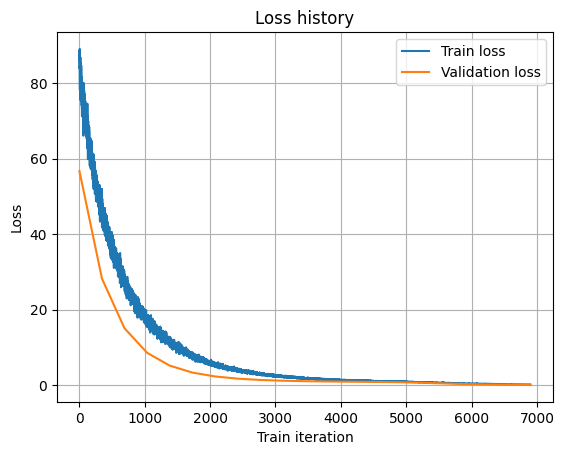

MAP@10 evaluation of the MFMSE model: 0.00012


In [7]:
mf_train = train_model(MFMSE(), batch_size=4096, epochs=20, embedding_dim=64)

We see that the MSE loss is not effective and leads to poor performance in terms of MAP@10.

## 3. BPR Loss
The Bayesian Personalized Ranking loss should be more effective as the dataset uses implicit feedback.